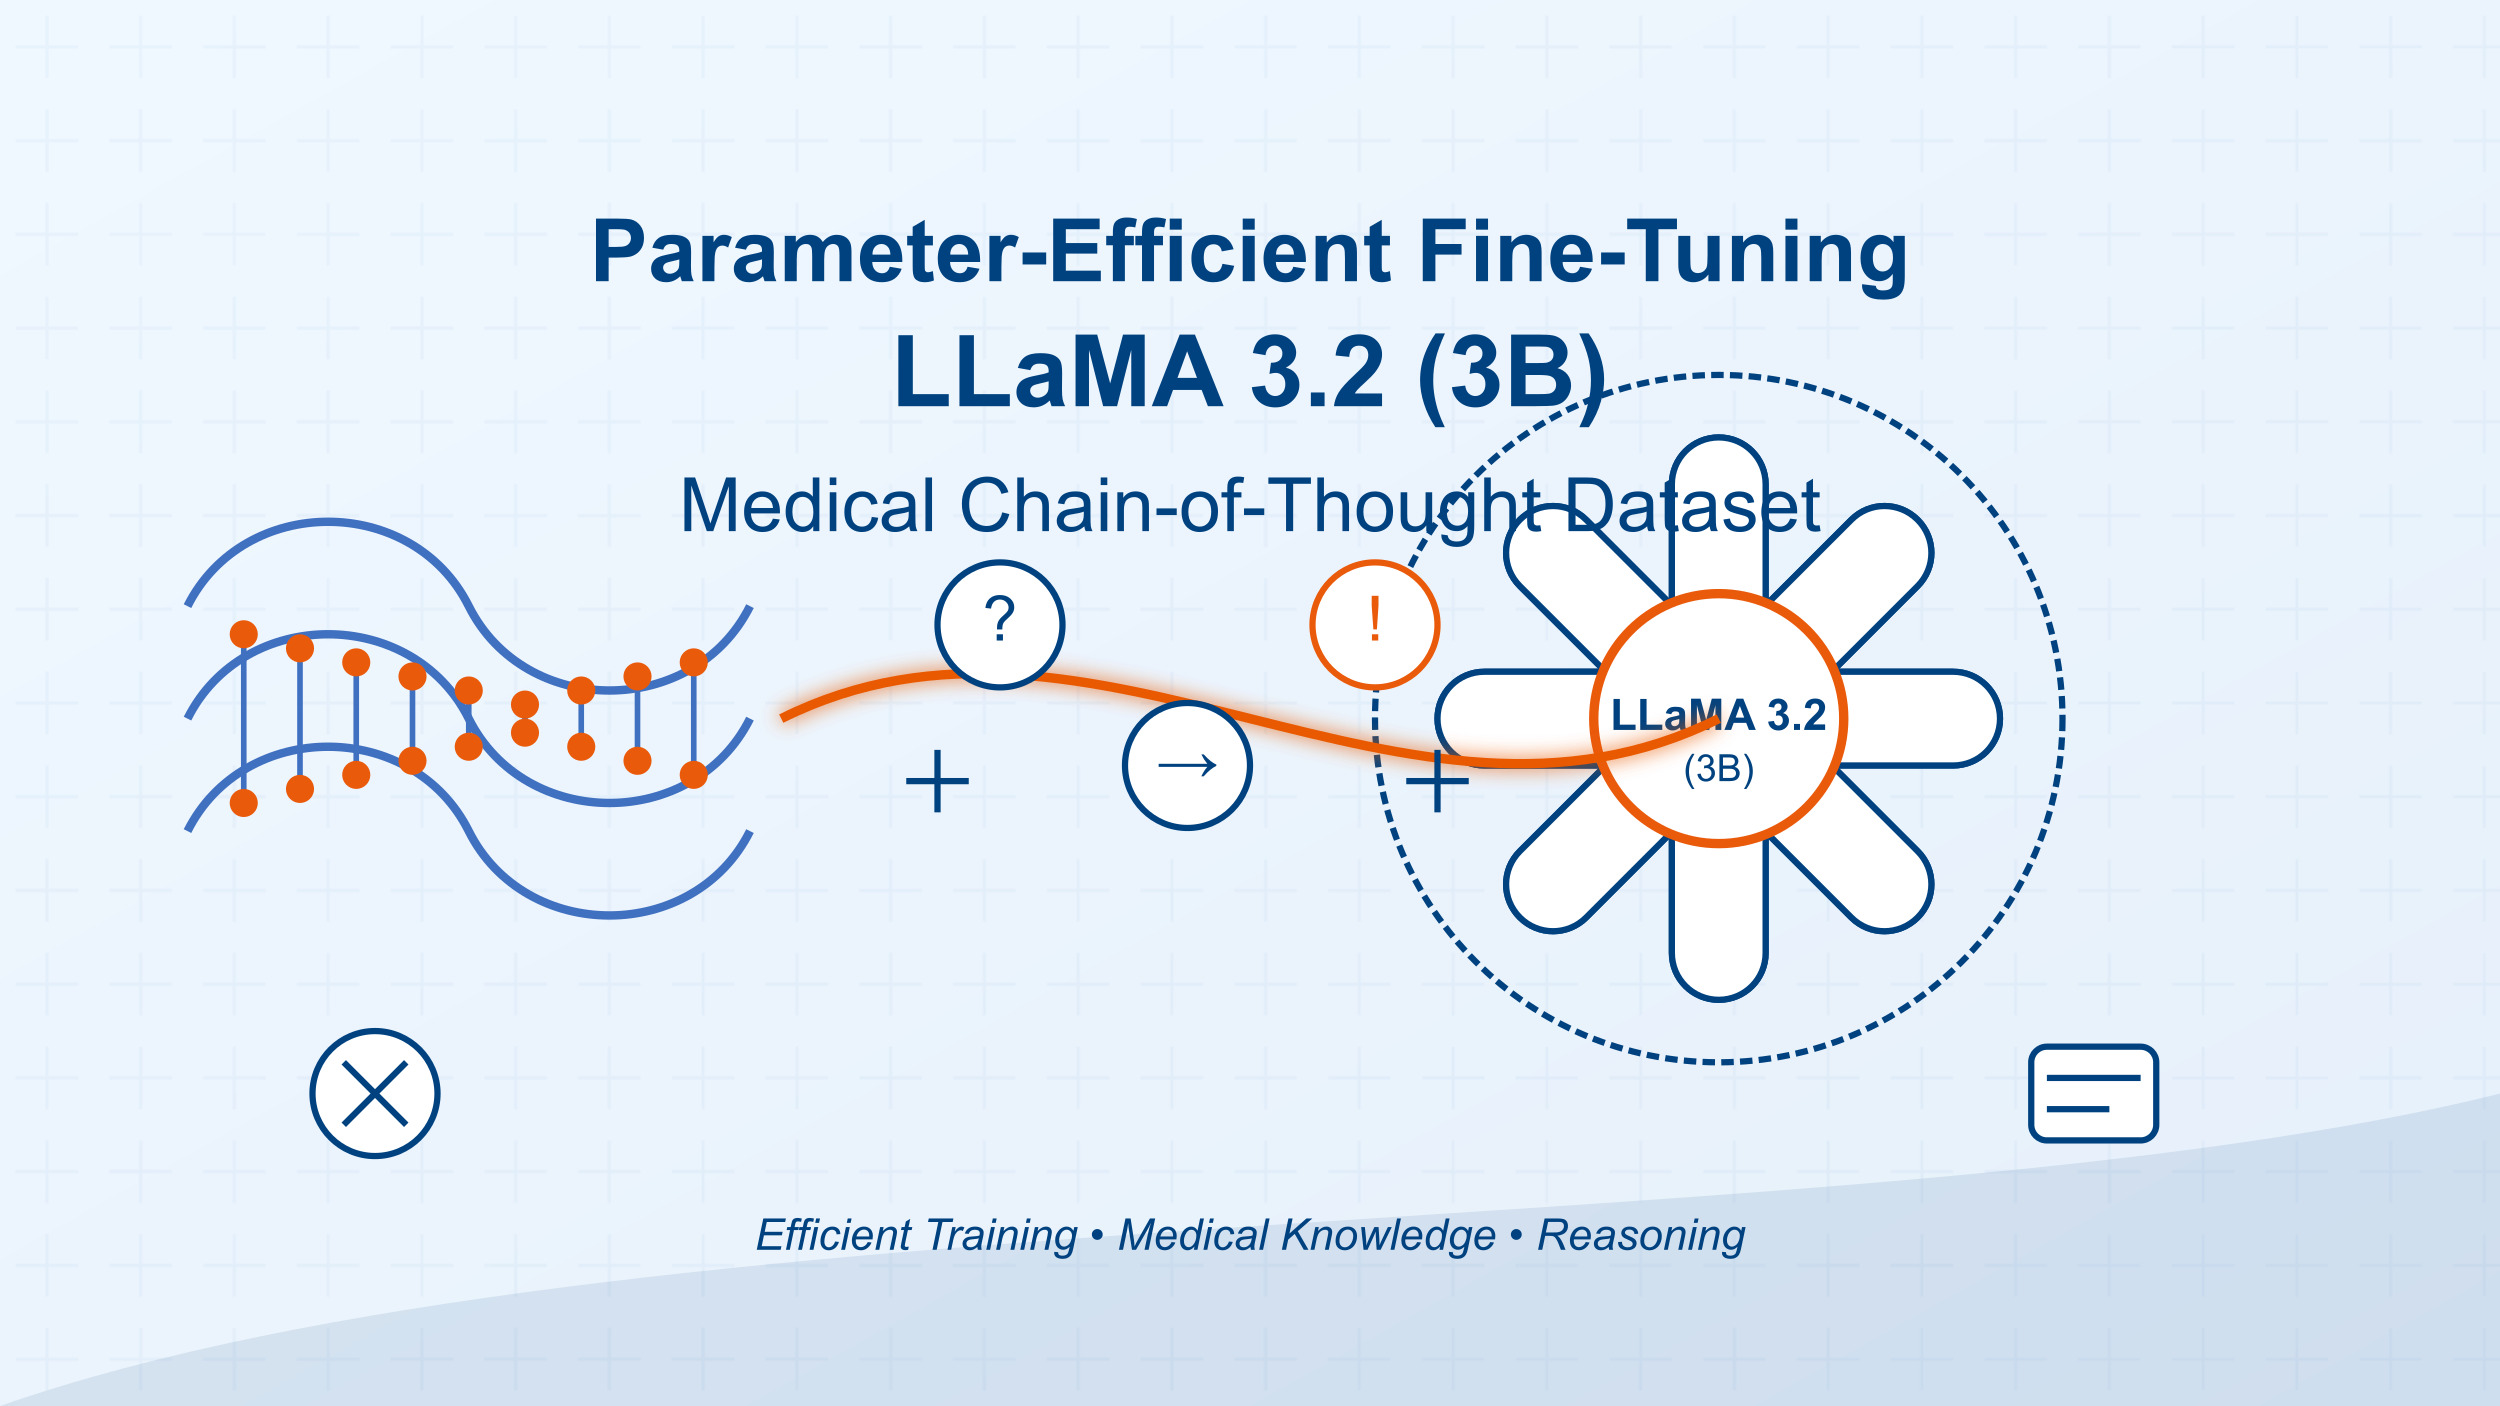

**Setting up the Environment**


In [1]:
# Install required Libraries
# !pip install unsloth datasets trl wandb
# !pip install vllm

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [3]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 1.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/12

In [4]:
import torch
assert torch.cuda.is_available(), "GPU required for efficient fine‑tuning"
print("GPU device:", torch.cuda.get_device_name(0))

AssertionError: GPU required for efficient fine‑tuning

In [ ]:
import wandb
wandb.login(key="c84cd416b5114205cfafeb20c02610bb28589157")

**Dataset Preparation & Loading**

In [ ]:
# Loading the dataset
from datasets import load_dataset
ds = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT","en", split="train", trust_remote_code=True)

In [ ]:
print(ds)

In [ ]:
ds = ds.shuffle(seed=42)
ds_valid = ds.select(range(100))
ds_train = ds.select(range(100, len(ds)))

**Prompt Formatting & Split**

In [ ]:
def format_cot(example):
    prompt = (
        "<system>You are a medical expert...</system>\n"
        f"<user>Question: {example['Question']}</user>\n"
        f"<think>{example['Complex_CoT']}</think>\n"
        f"<response>{example['Response']}</response>"
    )
    return {"prompt": prompt}

ds_train = ds_train.map(format_cot)
ds_valid = ds_valid.map(format_cot)

**Load base model & LoRA**

In [ ]:
from unsloth import FastLanguageModel
model, _ = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    max_seq_length=1024,
    fast_inference=True,
    gpu_memory_utilization=0.7,
)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj","k_proj","v_proj","o_proj",
        "gate_proj","up_proj","down_proj"
    ],
    lora_alpha=32,
    use_gradient_checkpointing="unsloth",
    random_state=3407
)

**Configure & Run Fine-tuning**

In [ ]:
from trl import SFTConfig

training_args = SFTConfig(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=2e-5,
    fp16=True,  # ✅ faster and memory-efficient
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,                # Evaluate every 100 steps
    save_strategy="steps",         # ✅ Save checkpoints every `save_steps`
    save_steps=100,                # ✅ Save every 100 steps
    save_total_limit=5,
    report_to="wandb",             # Logs to wandb
    output_dir="llama3.2-medcot-lora",  # Where to store checkpoints
    dataset_text_field="prompt",
    seed=42,
)


In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    tokenizer=None  # Unsloth handles it internally
)


In [ ]:
trainer.train()

**Save Adapter & Tokenizer**

In [ ]:
# Save LoRA adapter
trainer.model.save_lora("llama3.2-medcot-lora")

# Save tokenizer explicitly
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")
tokenizer.save_pretrained("llama3.2-medcot-lora_token")

print("Saved Successfully!")


In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login

# Login with your Hugging Face token
login(token="HF_API_KEY")

In [ ]:
from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder

repo_id = "Hums003/PEFT_LlaMA_3.2_MCoT"  # Your HF username/repo
local_path = "/content/llama3.2-medcot-lora"  

# Create repo 
create_repo(repo_id, exist_ok=True)

# Upload folder to repo
upload_folder(
    repo_id=repo_id,
    folder_path=local_path,
    commit_message="Upload model from Kaggle"
)


In [ ]:
from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder

repo_id = "Hums003/PEFT_LlaMA_3.2_MCoT"  # Your HF username/repo
local_path = "/content/llama3.2-medcot-lora_token"  

# Create repo 
create_repo(repo_id, exist_ok=True)

# Upload folder to repo
upload_folder(
    repo_id=repo_id,
    folder_path=local_path,
    commit_message="Upload tokenizer from Kaggel"
)

**Rouge-L Score**

In [ ]:
!pip install evaluate

In [ ]:
!pip install rouge_score

In [ ]:
import evaluate
from unsloth import FastLanguageModel
from transformers import AutoTokenizer

# Initialize ROUGE evaluation metric
rouge = evaluate.load("rouge")

# Generate and collect predictions & references
predictions = []
references  = []

for example in ds_valid:
    prompt = example["prompt"]
    # Separate reference answer (text inside <response>…</response>)
    ref = prompt.split("<response>")[1].split("</response>")[0].strip()
    references.append(ref)

    # Tokenize and generate
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.7,
        top_p=0.9,
        do_sample=False,  # deterministic for evaluation
        pad_token_id=tokenizer.eos_token_id
    )
    out = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Extract generated response segment
    if "<response>" in out and "</response>" in out:
        pred = out.split("<response>")[1].split("</response>")[0].strip()
    else:
        pred = out.strip()
    predictions.append(pred)

# Compute ROUGE‑L
results = rouge.compute(predictions=predictions, references=references, rouge_types=["rougeL"])

# The output is directly a float, so just print it
print(f"🍀 ROUGE‑L on validation set: {results['rougeL']:.4f}")